# **Feature Extraction: Help Computers to "Sense" the Images**

<font color='red' face='Times New Roman'>*NOTE: Before running this code, please create a folder named ``Figures`` in the root directory of your Google Drive.
Then, upload the 5 ``.jpg`` images to that folder.
Or you can directly save the following folder in your own Google Drive.*</font>

https://drive.google.com/drive/folders/1vmBVgxonnSXRTgkLr60dA0Rl7Sl7Da9i?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%pip install -U opencv-python

Mounted at /content/drive
     |████████████████████████████████| 60.4 MB 1.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Computers know numbers only. We have to quantize the characteretics we see from images into computer readable feature vectors so that they can "sense" what inside the images. Let's start with the Color Histogram. It helps computers the sense the color compositions of images.

# **1. Color Histograms**

To begin with, we can extract the histograms of gray images first.

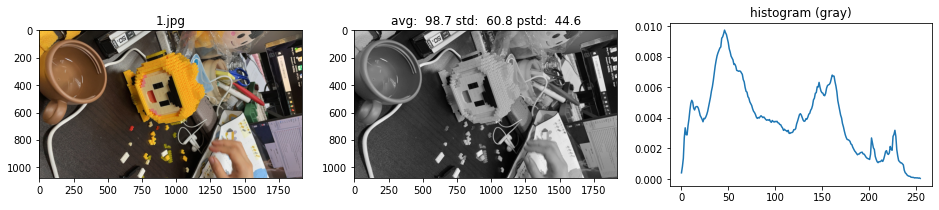

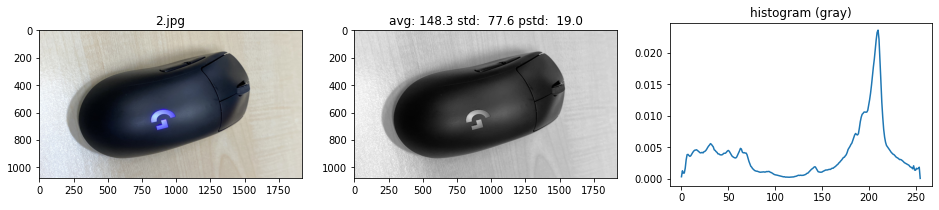

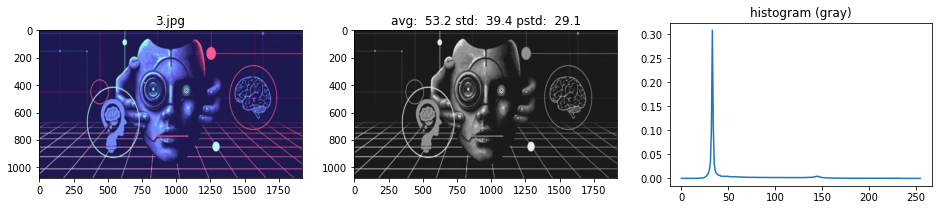

In [ ]:
import os
import cv2
import numpy as np
import urllib.request
from matplotlib import pyplot as plt

img_ext = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp']

def is_image(fname : str) -> bool:
    return any(fname.lower().endswith(ext) for ext in img_ext)

def patch_std(img : np.array, n_divide : int = 4) -> float:
    """ Calculate mean std on n_divide x n_divide patches
    
    Params:
        img:
            An image with size of H x W [x C], where channel is ignored.
        n_divide:
            Cut into n_divide parts along each dimension (H and W).
    """
    patches = [j for i in np.array_split(img, n_divide, axis=0)
                 for j in np.array_split(i, n_divide, axis=1)]
    return np.mean(list(map(np.std, patches)))

def gray_histogram(img : np.array, norm : bool = True) -> np.array:
    """ Count the single-channel histogram
    
    Params:
        img:
            An image with size of H x W.
        norm:
            Whether normalize the sum of the histogram to 1.
    """
    hist = np.array([len(img[img == i]) for i in range(256)])
    if norm:
        return hist / np.size(img)
    return hist

# configurations
src = '/content/drive/MyDrive/Figures'
img_names = ['1.jpg', '2.jpg', '3.jpg']


imgs = {}

for fname in img_names:
    plt.figure(figsize=(16, 3))
    fpath = os.path.join(src, fname)
    
    # Display image
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1] # BGR channels
    imgs[fname] = img
    plt.subplot(131)
    plt.title(fname)
    plt.imshow(img)
    
    # Display gray image
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.subplot(132)
    plt.title('avg: %5.1f std: %5.1f pstd: %5.1f' % (np.mean(img_gray),
                                                     np.std(img_gray),
                                                     patch_std(img_gray, 10)))
    plt.imshow(img_gray, cmap='gray')

    # Show gray-color histogram
    # img_gray = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(133)
    count_gray = gray_histogram(img_gray)
    plt.title('histogram (gray)')
    # plt.ylim(0, 0.025)
    plt.plot(range(256), count_gray)

# ------------------------------------------------------------------------------
# Note:
#   1.jpg is with complex background
#   2.jpg is with foreground more distinguishable from the background
#   3.jpg is darker than the other two
# ------------------------------------------------------------------------------

Do you see the difference. The image-3 which is darker than the other two has a histogram with values distributed more in the range of [30, 40] indicating that most its pixels are with values in that range. It thus make the image appreared darkers.

For that of the image-2, there are two peaks of the histograms. One is in the range of [0, 80] which consists of foreground pixels, which the other is in the range of [150, 250] which consists of background.

This is how histograms help the computers to sense the brightness and constrast of images. Similarly, we can apply this to the 3 channels (i.e., RGB) of the images. That's the idea of Color Histograms.

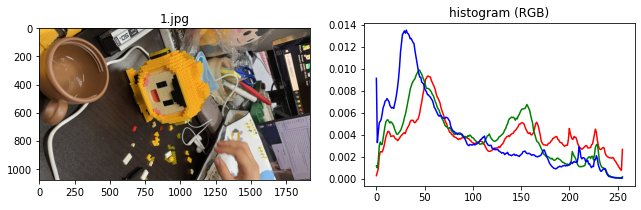

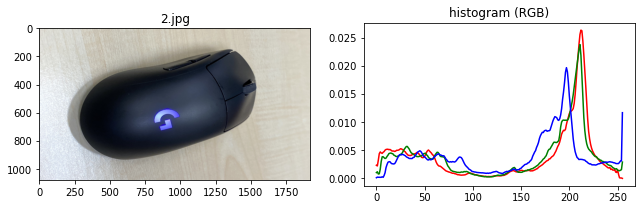

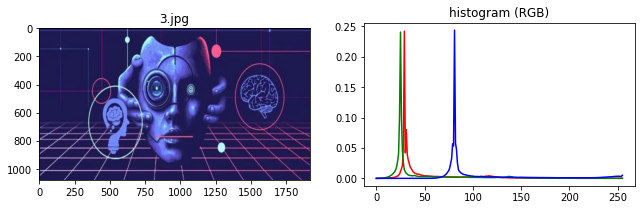

In [ ]:
# draw the RGB color histograms of these images


def color_histogram(img : np.array, norm : bool = True) -> np.array:
    """ Count the multi-channel histogram
    
    Params:
        img:
            An image with size of H x W x C.
        norm:
            Whether normalize the sum of the histogram for each channel to 1.
    """
    return np.array([gray_histogram(img[..., i], norm=norm) for i in range(3)])

for k, img in imgs.items():
    plt.figure(figsize=(10.67, 3))
    
    plt.subplot(121)
    plt.title(k)
    plt.imshow(img)
    
    plt.subplot(122)
    plt.title('histogram (RGB)')
    hists = color_histogram(img)
    plt.plot(range(256), hists[0], color='r')
    plt.plot(range(256), hists[1], color='g')
    plt.plot(range(256), hists[2], color='b')

See? Now computers can sense the colors.

# **2. LBP: Local Binary Pattern** 

LBP help the computer sense the textures. Let's see what it is through examples.

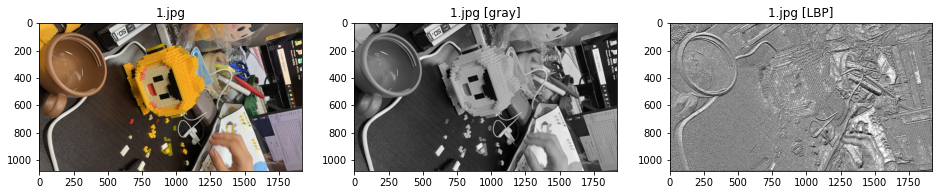

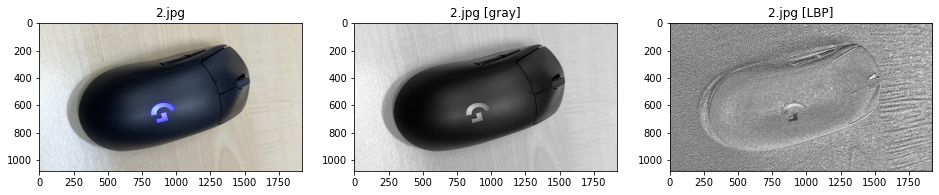

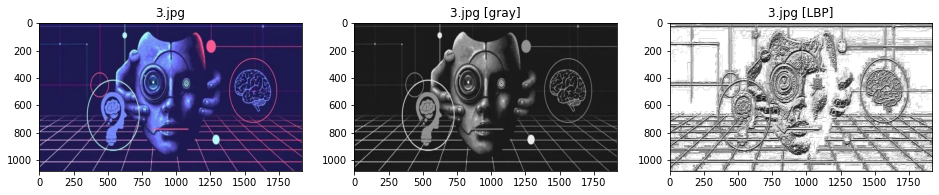

In [ ]:
# find two images from IMHere with different textures
# draw the LBP pattern images and feature vectors

def unfold(img : np.array, ksize : int = 3) -> np.array:
    """ unfold without center point, only odd kernel size is supported
    
    Params:
        img:
            An image with size of H x W.
        ksize:
            The kernel size
    """
    assert ksize % 2 == 1
    assert img.ndim == 2
    H, W = img.shape
    target = np.zeros((H+ksize-1, W+ksize-1, ksize**2-1), dtype=img.dtype)
    n = 0
    for h in range(ksize):
        for w in range(ksize):
            if h == ksize // 2 and w == ksize // 2:
                continue
            target[h:h+H, w:w+W, n] = img
            n += 1
    return target[ksize//2:ksize//2+H, ksize//2:ksize//2+W, :]


def original_LBP(img : np.array) -> np.array:
    """ calculate the original version of LBP
    
    Params:
        img:
            An image with size of H x W.
            
    Pattern:
        4 3 2
        5 / 1
        6 7 8
    """
    img_unfold = unfold(img)
    factor1 = img_unfold >= img[..., None]
    factor2 = np.array([128, 64, 32, 1, 16, 2, 4, 8], dtype=np.int32)
    return np.sum((factor1 * factor2), axis=-1)


for k, img in imgs.items():
    plt.figure(figsize=(16, 3))
    
    plt.subplot(131)
    plt.title(k)
    plt.imshow(img)
    
    plt.subplot(132)
    plt.title(k + ' [gray]')
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(img_gray, cmap='gray')
    
    plt.subplot(133)
    plt.title(k + ' [LBP]')
    LBP = original_LBP(img_gray)
    plt.imshow(LBP, cmap='gray')




# **3. Local Features: SIFT**

Local features help computers sense the details of images. Let's try SIFT.

<font face='Times New Roman'>*The patent period of the SIFT algorithm has ended on March 6, 2020, please feel free to use it in commercial and academic scenarios!*</font>

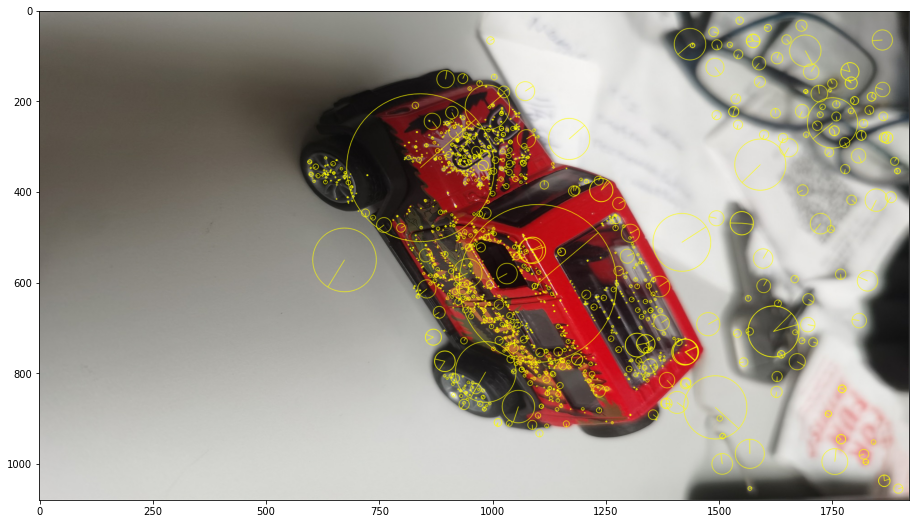

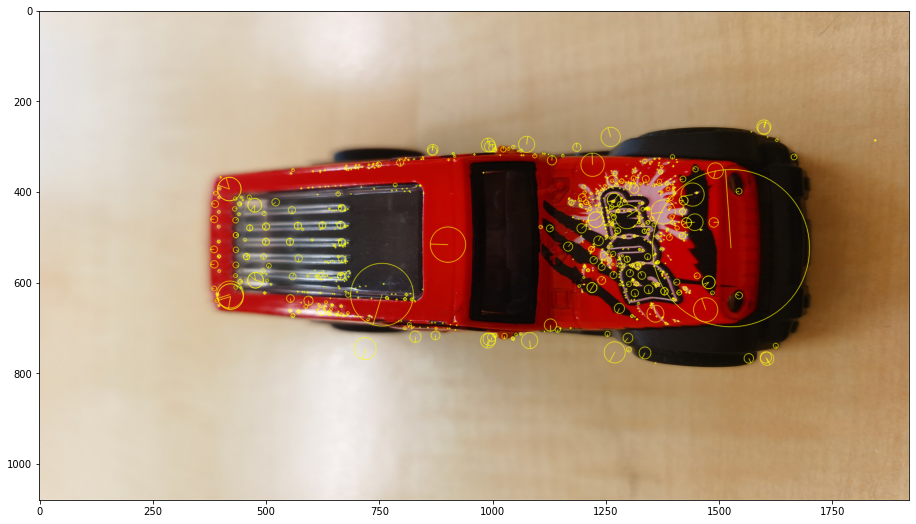

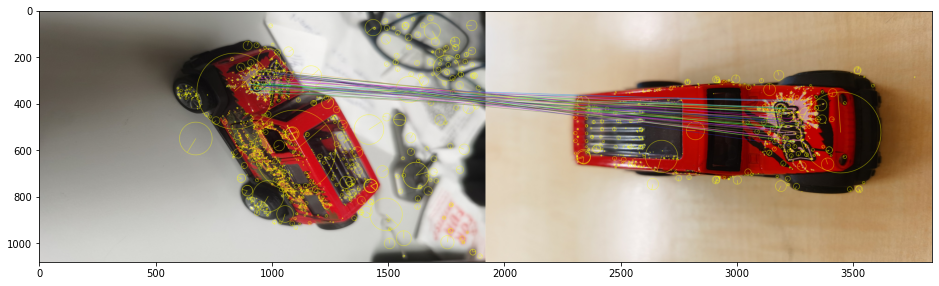

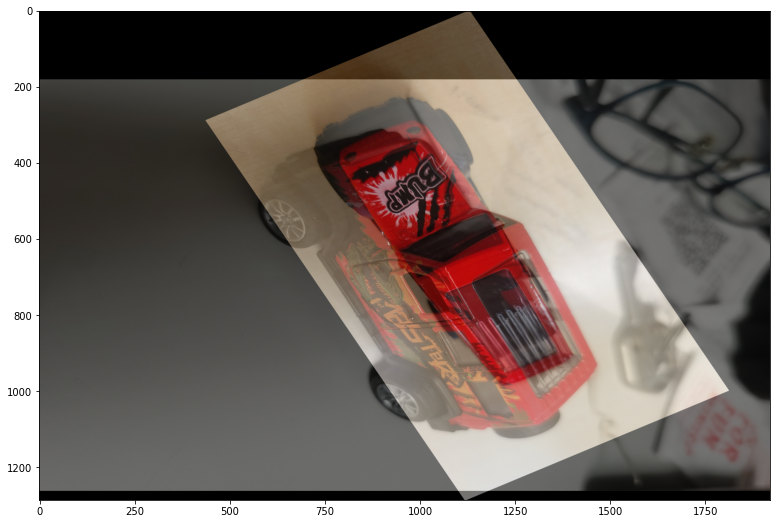

In [ ]:
def dst_pos(aff, img_size, img_size2):
    pts = np.array([[0, 0, 1], [0, img_size[1], 1], [img_size[0], 0, 1], [*img_size, 1]])
    min_w = min_h = float('inf')
    max_w = max_h = 0
    for pt in pts:
        dst_w, dst_h = np.dot(aff, pt)
        min_w = min(min_w, dst_w)
        min_h = min(min_h, dst_h)
        max_w = max(max_w, dst_w)
        max_h = max(max_h, dst_h)
    min_w = int(min_w)
    min_h = int(min_h)
    max_w = int(max_w)
    max_h = int(max_h)
    add_w, add_h = max(-min_w, 0), max(-min_h, 0)
    min_w += add_w
    min_h += add_h
    max_w += add_w
    max_h += add_h
    return max(max_w, img_size2[0]+add_w), max(max_h, img_size2[1]+add_h), add_w, add_h

def matchSift(image_path1, image_path2):
    img1 = cv2.imread(image_path1, cv2.IMREAD_COLOR)[..., ::-1]
    img2 = cv2.imread(image_path2, cv2.IMREAD_COLOR)[..., ::-1]
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    img1_kp = img1.copy()
    img2_kp = img2.copy()
    cv2.drawKeypoints(img1, kp1, img1_kp, (255, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2.drawKeypoints(img2, kp2, img2_kp, (255, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    goodMatch = []
    for m, n in matches:
        if m.distance < 0.5*n.distance:
            goodMatch.append(m)
    goodMatch_np = np.expand_dims(goodMatch, 1)
    query_points = []
    train_points = []
    for m in goodMatch:
        query_points.append(kp1[m.queryIdx].pt)
        train_points.append(kp2[m.trainIdx].pt)
    query_points = np.array(query_points)
    train_points = np.array(train_points)
    AffineMatrixImg2, _ = cv2.estimateAffine2D(train_points, query_points)
    max_w, max_h, add_w, add_h = dst_pos(AffineMatrixImg2, img2.shape[1::-1], img1.shape[1::-1])
    AffineMatrixImg2[:, 2] += (add_w, add_h)
    AffineMatrixImg1 = np.array([[1, 0, add_w], [0, 1, add_h]], dtype=AffineMatrixImg2.dtype)
    img1 = cv2.warpAffine(img1, AffineMatrixImg1, (max_w, max_h))
    img2 = cv2.warpAffine(img2, AffineMatrixImg2, (max_w, max_h))
    img_res = (((img1.astype(np.int32)+img2.astype(np.int32))) / 2).astype(np.uint8)
    img_out = cv2.drawMatchesKnn(img1_kp, kp1, img2_kp, kp2, goodMatch_np, None, flags=2)
    plt.figure(figsize=(16, 9))
    plt.imshow(img1_kp)
    plt.figure(figsize=(16, 9))
    plt.imshow(img2_kp)
    plt.figure(figsize=(16, 9))
    plt.imshow(img_out)
    plt.figure(figsize=(16, 9))
    plt.imshow(img_res)

src = '/content/drive/MyDrive/Figures'
matchSift(os.path.join(src, '4.jpg'), os.path.join(src, '5.jpg'))